# Cryptocurrency Price Forecasting

In [56]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates


In [40]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('all_currencies.csv',parse_dates=['Date'], index_col='Date',
               date_parser=dateparse)
df=pd.read_csv('all_currencies.csv')
df= df.assign(Date = pd.to_datetime(df['Date']))
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [45]:
df.tail()

,Date,Symbol,Open,High,Low,Close,Volume,Market Cap
632213,2018-09-23,ZZC,0.067149,0.067324,0.024069,0.024161,34.0,130705.0
632214,2018-09-24,ZZC,0.024167,0.091875,0.024121,0.091631,58.0,47041.0
632215,2018-09-25,ZZC,0.091528,0.091568,0.057507,0.090547,752.0,178158.0
632216,2018-09-26,ZZC,0.090400,0.104745,0.086071,0.086559,60.0,175963.0
632217,2018-09-27,ZZC,0.086664,0.130541,0.067363,0.073475,91.0,168691.0


In [43]:
df.dtypes

Date          datetime64[ns]
Symbol                object
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume               float64
Market Cap           float64
dtype: object

# Bitcoin

In [46]:
df_btc = df[df['Symbol']=='BTC']

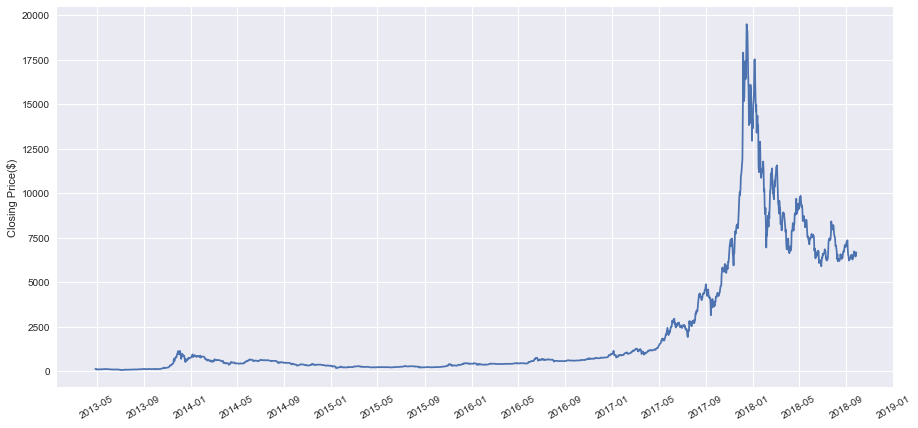

In [109]:
fig, ax = plt.subplots(figsize=(15,7))

plt.plot(df_btc['Date'],df_btc['Close'])
plt.ylabel('Closing Price($)')
majorFmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,5,9]))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
plt.show()


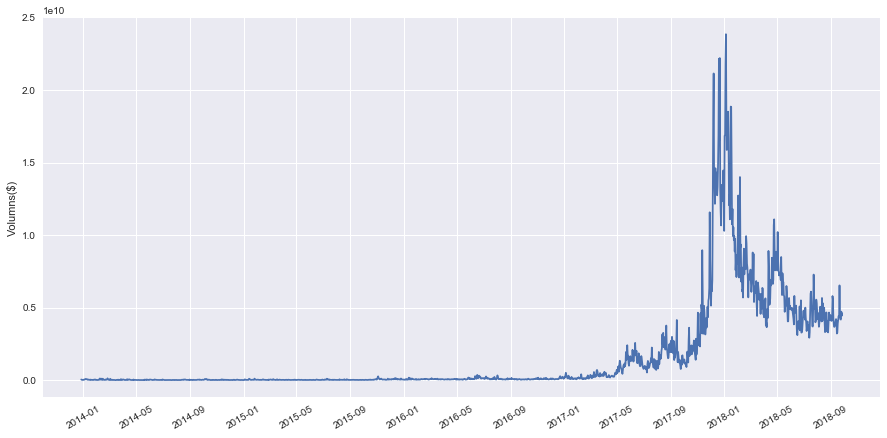

In [110]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(df_btc['Date'], df_btc['Volume'])
plt.ylabel('Volumns($)')
majorFmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,5,9]))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)

plt.show()

# AR, MA & ARMA

In [111]:
#import package for ARIMA 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


/Applications/Anaconda/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Check stationarity 

A stationary time seires is one whose mean is constant over time and covaraince  cov($X_t,X_{t+h})$ does not depend on t.

We need to make sure that the time series data is stationary to use the ARMA model.

In [117]:
df_btc = df_btc.set_index('Date')

In [133]:
print('First day record : {}'.format(df_btc.index[0]))
print('Last day record: {}'.format(df_btc.index[-1]))

First day record : 2013-04-28 00:00:00
Last day record: 2018-09-27 00:00:00


In [119]:
# Resampling to monthly frequency
btc_month = df_btc.resample('M').mean()


Dickey–Fuller test: p=0.695832


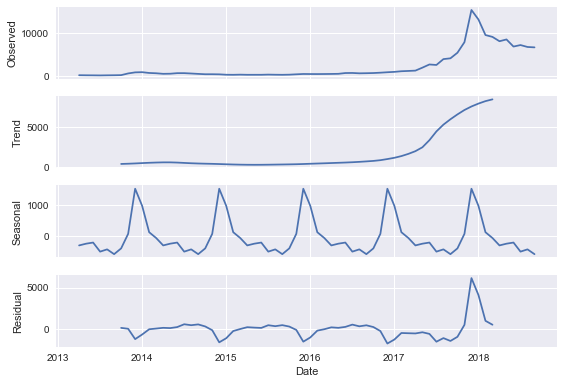

In [136]:
seasonal_decompose(btc_month.Close, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close)[1])
plt.show()

The p-value indicates that series is not stationary with 0.69% confidence

We observed that the bitcoin price is somewhat stable before 2017, but experienced an amazing growth in the end of 2017, and then crashed a certain amount in 2018.

There is a seasonal condition in annual basis

The residual ...

## Differencing

We need to use differencing method to make the series data stationary.


In [138]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.Close - btc_month.Close.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.516082


In [141]:
# Seasonal differentiation (6 months)
btc_month['box_diff_seasonal_6'] = btc_month.Close - btc_month.Close.shift(6)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_6[6:])[1])

Dickey–Fuller test: p=0.873251


In [142]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.Close - btc_month.Close.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.010645


In [143]:
# Seasonal differentiation (1 months)
btc_month['box_diff_seasonal_1'] = btc_month.Close - btc_month.Close.shift(1)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_1[1:])[1])

Dickey–Fuller test: p=0.000000


Dickey–Fuller test: p=0.000000


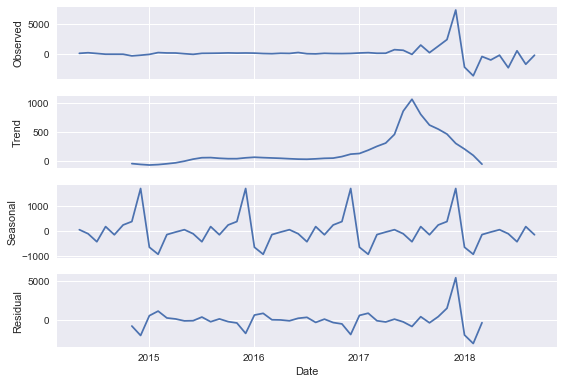

In [147]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])
plt.show()

## ACF

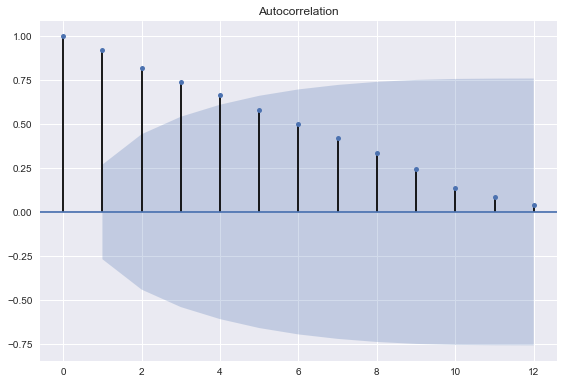

In [150]:
#autocorrelation_plot(btc_month.close)
plot_acf(btc_month.Close[13:].values.squeeze(), lags=12)
plt.tight_layout()
plt.show()